# Requirements

In [37]:
from collections import defaultdict
import matplotlib.pyplot as plt
import random
%matplotlib inline

# Implementation

First we define a class to evolve the cellular autotomaton.  A runner is created for a specific rule, specified by a number between 0 and 255.  For instance, rule 47 would translate to:
* $000 \mapsto 1$
* $001 \mapsto 1$
* $010 \mapsto 1$
* $011 \mapsto 1$
* $100 \mapsto 0$
* $101 \mapsto 1$
* $110 \mapsto 0$
* $111 \mapsto 0$

In [2]:
class AutomatonRunner:
    
    def __init__(self, rule_nr):
        self._compute_rules(rule_nr)
        
    def _compute_rules(self, rule_nr):
        self._rules = []
        for _ in range(8):
            self._rules.append(rule_nr % 2)
            rule_nr //= 2
    
    def _apply_rule(self, environment):
        env_nr = 4*environment[0] + 2*environment[1] + environment[2]
        return self._rules[env_nr]
    
    def _make_environment(self, automaton, i):
        if 0 < i < len(automaton) - 1:
            return automaton[i - 1:i + 2]
        elif i == 0:
            return [automaton[-1]] + automaton[:2]
        elif i == len(automaton) - 1:
            return automaton[i - 1:] + [automaton[0]]
        
    def next_generation(self, automaton):
        ng_automaton = []
        for i in range(len(automaton)):
            environment = self._make_environment(automaton, i)
            ng_automaton.append(self._apply_rule(environment))
        return ng_automaton
                                
    def evolve(self, automaton, nr_generations):
        generations = [automaton]
        for _ in range(nr_generations):
            generations.append(self.next_generation(generations[-1]))
        return generations
    
    def __str__(self):
        auto_str = ''
        for i, result in enumerate(self._rules):
            auto_str += f'{i//4 % 2}{i//2 % 2}{i % 2} -> {result}\n'
        return auto_str

To verify the implementation, we check whether the rules have been created correctly.

In [3]:
runner = AutomatonRunner(47)

In [4]:
print(str(runner))

000 -> 1
001 -> 1
010 -> 1
011 -> 1
100 -> 0
101 -> 1
110 -> 0
111 -> 0



# Running an automaton

We create an automaton that is reandomly initialized.

In [5]:
automaton = random.choices((0, 1), k=10)

In [6]:
generations = runner.evolve(automaton, 10)

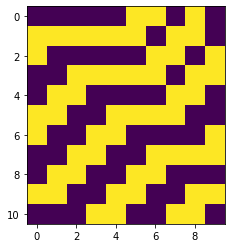

In [7]:
plt.imshow(generations)

# Exploring rules

In [9]:
nr_cols = 16
nr_generations = 80
figure, axes = plt.subplots(256//nr_cols, nr_cols, figsize=(100, 100))
automaton = random.choices((0, 1), k=20)
for rule_nr in range(256):
    row_nr = rule_nr//nr_cols
    col_nr = rule_nr % nr_cols
    runner = AutomatonRunner(rule_nr)
    generations = runner.evolve(automaton, nr_generations)
    axes[row_nr][col_nr].imshow(generations, aspect='auto')
    axes[row_nr][col_nr].set_title(str(rule_nr));
plt.tight_layout()

Rule 129 seems to be interesting.

In [16]:
runner = AutomatonRunner(129)

In [17]:
automaton = random.choices((0, 1), k=200)

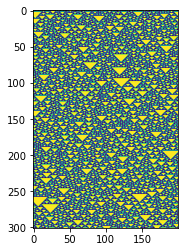

In [18]:
plt.imshow(runner.evolve(automaton, 300))

# Finding cycles

It is clear that all automata have to cycle eventually.  If the number of cells in the automaton is $N$, there are only $2^N$ distinct configurations, so the maximum length of a cycle must be less than or equal to $2^N$.  However, we can compute the distribution of cycle lenghts over the rules.

In [13]:
def find_cycle(rule_nr, automaton, max_generations=100):
    runner = AutomatonRunner(rule_nr)
    generations = [automaton]
    for gen_nr in range(max_generations):
        generations.append(runner.next_generation(generations[-1]))
        pos = generations.index(generations[-1])
        if pos < len(generations) - 1:
            return gen_nr, len(generations) - 1 - pos
    return max_generations, None

In [23]:
automaton = random.choices((0, 1), k=10)

In [24]:
find_cycle(129, automaton)

(6, 6)

In [49]:
lengths = defaultdict(lambda: 0)
offsets = defaultdict(lambda: 0)
for rule_nr in range(256):
    offset, length = find_cycle(rule_nr, automaton, max_generations=1024)
    offsets[offset] += 1
    lengths[length] += 1

In [50]:
type(lengths)

collections.defaultdict

In [51]:
lengths

defaultdict(<function __main__.<lambda>()>,
            {1: 78,
             2: 24,
             10: 80,
             20: 34,
             4: 8,
             15: 8,
             40: 2,
             430: 4,
             30: 4,
             6: 10,
             205: 4})

In [60]:
x = list(range(max(lengths) + 1))
plt.rcParams['figure.figsize'] = (500, 100)
plt.bar(x, [lengths[l] for l in x])

<BarContainer object of 431 artists>

<BarContainer object of 21 artists>

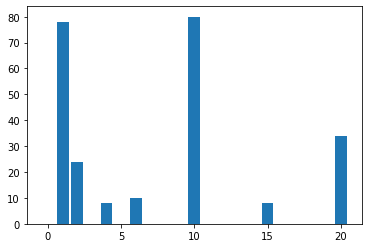

In [56]:
x = list(range(21))
plt.bar(x, [lengths[l] for l in x])

There are a few rules that have very large cycle lengths, although less than $2^N$.

In [ ]:
for _ in range(20):
    automaton = random.choices((0, 1), k=10)
    